In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


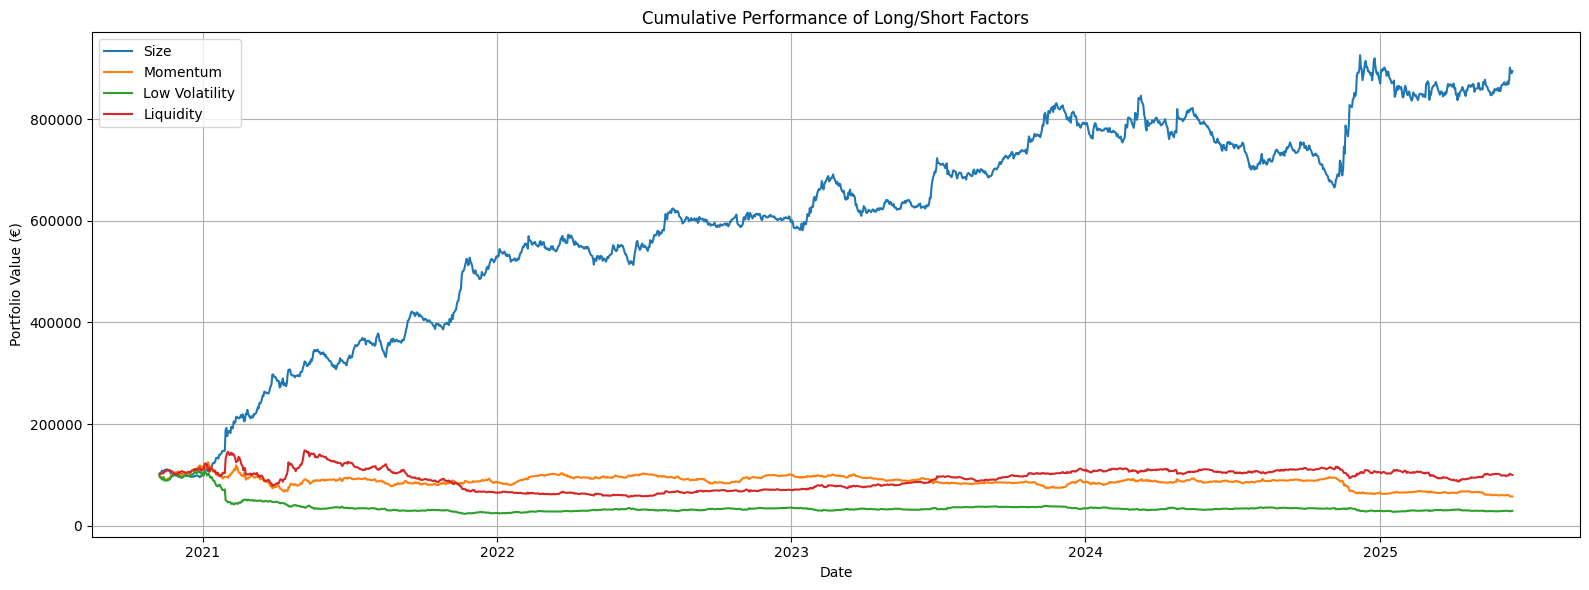


📊 Individual Factor Performance:

🔹 Size Factor:
Initial Capital                  100,000 €
Final Capital                    894,479 €
Total Return                      794.48 %
Annual Return (APY)                61.01 %
Annual Volatility                  27.16 %
Sharpe Ratio                          1.81
Sortino Ratio                         3.77
Max Drawdown                      -21.34 %
Start Date             2020-11-08 00:00:00
End Date               2025-06-14 00:00:00
Days                                  1679
dtype: object
------------------------------------------------------------
🔹 Momentum Factor:
Initial Capital                  100,000 €
Final Capital                     57,471 €
Total Return                      -42.53 %
Annual Return (APY)               -11.34 %
Annual Volatility                  26.84 %
Sharpe Ratio                         -0.39
Sortino Ratio                        -0.52
Max Drawdown                      -54.21 %
Start Date             2020-11-08 00:00

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load local data
def load_local_data(folder_path):
    price_df = pd.DataFrame()
    mcap_df = pd.DataFrame()
    volume_df = pd.DataFrame()

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            symbol = file.split('-')[0].lower()
            df = pd.read_csv(os.path.join(folder_path, file))
            df['date'] = pd.to_datetime(df['snapped_at']).dt.tz_localize(None)
            df = df.set_index('date').sort_index()

            price_df[symbol] = df['price']
            mcap_df[symbol] = df['market_cap']
            volume_df[symbol] = df['total_volume']

    returns = price_df.pct_change(fill_method=None).dropna()
    volatility = returns.rolling(30).std()
    for df in [returns, price_df, mcap_df, volume_df, volatility]:
        df.index = df.index.tz_localize(None)


    return returns, price_df, mcap_df, volume_df, volatility

# 2. Size Factor
def compute_size_factor_mcap(returns, market_cap, signal_window, backtest_window, quantile=0.3):
    size_factor = pd.Series(dtype=float, index=returns.index)
    for start in range(0, len(returns), backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > len(returns): break

        dates_signal = returns.index[start:sig_end]
        dates_back = returns.index[sig_end:bt_end]
        mcap_avg = market_cap.loc[dates_signal].mean()
        inv_mcap = 1.0 / mcap_avg.replace(0, np.nan).dropna()
        if inv_mcap.empty: continue

        q_top = inv_mcap.quantile(1 - quantile)
        q_bot = inv_mcap.quantile(quantile)
        small_caps = inv_mcap[inv_mcap >= q_top].index
        large_caps = inv_mcap[inv_mcap <= q_bot].index
        if len(small_caps) == 0 and len(large_caps) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        w[small_caps] = 1.0 / (2 * len(small_caps))
        w[large_caps] = -1.0 / (2 * len(large_caps))
        rets = returns.loc[dates_back].dropna(how='all', axis=1)
        daily_returns = rets[w.index].dot(w).dropna()
        size_factor.loc[daily_returns.index] = daily_returns
    return size_factor.rename("SizeFactor")

# 3. Momentum Factor
def compute_momentum_factor(returns: pd.DataFrame, signal_window: int, backtest_window: int, quantile: float = 0.3):
    n_days = len(returns)
    momentum_portfolio = pd.Series(dtype=float, index=returns.index)

    for start in range(0, n_days, backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > n_days:
            break

        dates_signal = returns.index[start:sig_end]
        date_signal = dates_signal[-1]
        dates_back = returns.index[sig_end:bt_end]

        returns_window = returns.loc[dates_signal]
        cum_returns = (returns_window + 1).prod() - 1
        std = returns_window.std()
        sharpe_like = cum_returns / std.replace(0, np.nan)

        z_cum = (cum_returns - cum_returns.mean()) / cum_returns.std()
        z_sharpe = (sharpe_like - sharpe_like.mean()) / sharpe_like.std()

        momentum_score = 0.5 * (z_cum + z_sharpe)
        momentum_score = momentum_score.dropna()
        if momentum_score.empty:
            continue

        q_top = momentum_score.quantile(1 - quantile)
        q_bot = momentum_score.quantile(quantile)

        long_assets = momentum_score[momentum_score >= q_top].index
        short_assets = momentum_score[momentum_score <= q_bot].index

        if len(long_assets) == 0 and len(short_assets) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        if len(long_assets) > 0:
            w[long_assets] = 1.0 / (2 * len(long_assets))
        if len(short_assets) > 0:
            w[short_assets] = -1.0 / (2 * len(short_assets))

        rets = returns.loc[dates_back].dropna(how='all', axis=1)
        rets = rets.loc[:, rets.columns.isin(w.index)]
        daily_returns = rets.dot(w).dropna()
        momentum_portfolio.loc[daily_returns.index] = daily_returns

    return momentum_portfolio.rename("MomentumFactor")


# 4. Low Volatility Factor
def compute_low_volatility_factor(returns, signal_window, backtest_window, quantile=0.3):
    low_vol = pd.Series(dtype=float, index=returns.index)
    for start in range(0, len(returns), backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > len(returns): break

        dates_signal = returns.index[start:sig_end]
        dates_back = returns.index[sig_end:bt_end]
        vol = returns.loc[dates_signal].std()

        low_vol_assets = vol[vol <= vol.quantile(quantile)].index
        high_vol_assets = vol[vol >= vol.quantile(1 - quantile)].index
        if len(low_vol_assets) == 0 and len(high_vol_assets) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        w[low_vol_assets] = 1.0 / (2 * len(low_vol_assets))
        w[high_vol_assets] = -1.0 / (2 * len(high_vol_assets))
        rets = returns.loc[dates_back].dropna(how='all', axis=1)
        daily_returns = rets[w.index].dot(w).dropna()
        low_vol.loc[daily_returns.index] = daily_returns
    return low_vol.rename("LowVolFactor")

# 5. Liquidity Factor (Turnover-based, long/short)
def compute_liquidity_factor(volume: pd.DataFrame, market_cap: pd.DataFrame, returns: pd.DataFrame,
                             signal_window: int, backtest_window: int, quantile: float = 0.3):
    n_days = len(returns)
    liquidity_factor = pd.Series(dtype=float, index=returns.index)

    for start in range(0, n_days, backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > n_days:
            break

        date_signal = returns.index[sig_end - 1]
        dates_back = returns.index[sig_end:bt_end]

        vol = volume.loc[volume.index <= date_signal].iloc[-signal_window:]
        mcap = market_cap.loc[market_cap.index <= date_signal].iloc[-signal_window:]

        turnover = vol / mcap
        avg_turnover = turnover.mean()
        liquidity_score = avg_turnover.dropna()

        if liquidity_score.empty:
            continue

        q_top = liquidity_score.quantile(1 - quantile)
        q_bot = liquidity_score.quantile(quantile)
        long_assets = liquidity_score[liquidity_score >= q_top].index
        short_assets = liquidity_score[liquidity_score <= q_bot].index

        if len(long_assets) == 0 and len(short_assets) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        if len(long_assets) > 0:
            w[long_assets] = 1.0 / (2 * len(long_assets))
        if len(short_assets) > 0:
            w[short_assets] = -1.0 / (2 * len(short_assets))

        rets = returns.loc[dates_back, returns.columns.intersection(w.index)].dropna(how='all', axis=1)
        daily_ret = rets.dot(w).dropna()
        liquidity_factor.loc[daily_ret.index] = daily_ret

    return liquidity_factor.rename("LiquidityFactor")

# 6. Plot cumulative performance
def plot_all_factors(factor_returns_dict, initial_capital=100_000):
    plt.figure(figsize=(16, 6))
    for name, series in factor_returns_dict.items():
        cum = (1 + series).dropna().cumprod() * initial_capital
        plt.plot(cum, label=name)
    plt.title("Cumulative Performance of Long/Short Factors")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (€)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 7. Performance metrics
def compute_performance_metrics(portfolio_returns, initial_capital=100_000, risk_free_rate=0.02):
    portfolio_returns = portfolio_returns.dropna()
    cum_curve = (1 + portfolio_returns).cumprod() * initial_capital
    total_days = (portfolio_returns.index[-1] - portfolio_returns.index[0]).days
    ann_return = (cum_curve.iloc[-1] / initial_capital) ** (365 / total_days) - 1
    ann_vol = portfolio_returns.std() * np.sqrt(365)
    excess_daily = portfolio_returns - risk_free_rate / 365
    sharpe = excess_daily.mean() / excess_daily.std() * np.sqrt(365)
    downside_std = portfolio_returns[portfolio_returns < 0].std()
    sortino = excess_daily.mean() / downside_std * np.sqrt(365) if downside_std > 0 else np.nan
    peak = cum_curve.cummax()
    drawdown = cum_curve / peak - 1
    max_dd = drawdown.min()

    return pd.Series({
        "Initial Capital": f"{initial_capital:,.0f} €",
        "Final Capital": f"{cum_curve.iloc[-1]:,.0f} €",
        "Total Return": f"{(cum_curve.iloc[-1]/initial_capital - 1)*100:.2f} %",
        "Annual Return (APY)": f"{ann_return*100:.2f} %",
        "Annual Volatility": f"{ann_vol*100:.2f} %",
        "Sharpe Ratio": round(sharpe, 2),
        "Sortino Ratio": round(sortino, 2),
        "Max Drawdown": f"{max_dd*100:.2f} %",
        "Start Date": portfolio_returns.index[0],
        "End Date": portfolio_returns.index[-1],
        "Days": total_days
    })

# 🔁 Main execution
folder_path = "/content/drive/Shareddrives/Sixteen01-2025/Data Factor Portfolio"
signal_window = 35
backtest_window = 80

returns, price, market_cap, volume, volatility = load_local_data(folder_path)

common_index = returns.index.intersection(price.index).intersection(market_cap.index).intersection(volume.index)
returns = returns.loc[common_index]
price = price.loc[common_index]
market_cap = market_cap.loc[common_index]
volume = volume.loc[common_index]
volatility = volatility.loc[common_index]


# Compute factors
size_factor = compute_size_factor_mcap(returns, market_cap, signal_window, backtest_window)
momentum_factor = compute_momentum_factor(returns, signal_window, backtest_window)
low_vol_factor = compute_low_volatility_factor(returns, signal_window, backtest_window)
liquidity_factor = compute_liquidity_factor(volume, market_cap, returns, signal_window, backtest_window)

# Dictionary of all factors
factors = {
    "Size": size_factor,
    "Momentum": momentum_factor,
    "Low Volatility": low_vol_factor,
    "Liquidity": liquidity_factor
}

# Plot all cumulative performances
plot_all_factors(factors)

# Print individual metrics
print("\n📊 Individual Factor Performance:\n")
for name, factor_series in factors.items():
    print(f"🔹 {name} Factor:")
    print(compute_performance_metrics(factor_series))
    print("-" * 60)

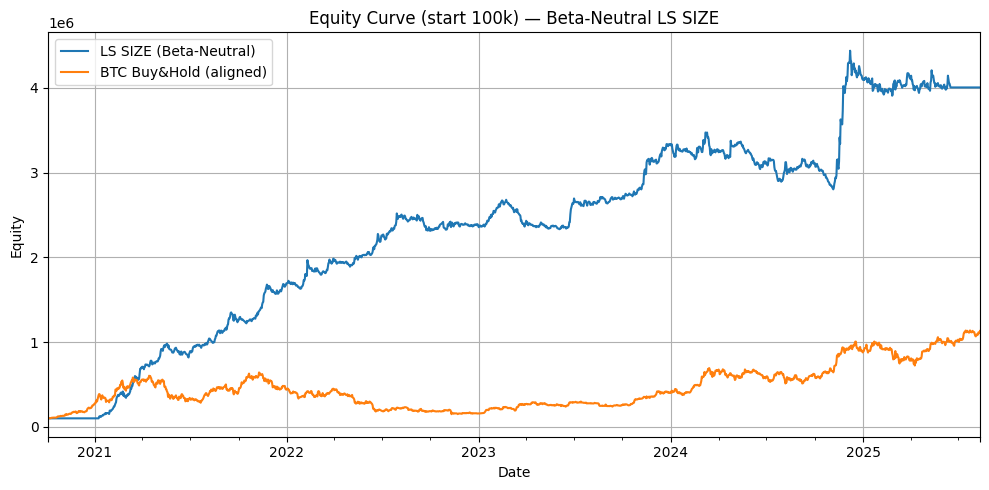

                Final Equity      CAGR   Vol Ann    Sharpe   Sortino  Max Drawdown    Calmar
LS_BetaNeutral  4.004836e+06  1.138472  0.330304  2.461300  4.605147     -0.193197  5.892798
BTC_Buy&Hold    1.130851e+06  0.648096  0.597881  1.134397  1.627846     -0.767182  0.844774


In [5]:
# ---------- Performance Statistics ----------
def perf_stats(equity, periods_per_year=365):
    rets = equity.pct_change().dropna()
    if len(rets) == 0:
        return {"Final Equity": float(equity.iloc[-1]) if len(equity) else np.nan,
                "CAGR": np.nan, "Vol Ann": np.nan, "Sharpe": np.nan,
                "Sortino": np.nan, "Max Drawdown": np.nan, "Calmar": np.nan}
    total_return = equity.iloc[-1] / equity.iloc[0] - 1
    years = len(rets) / periods_per_year
    cagr = (1 + total_return) ** (1/years) - 1
    vol_ann = rets.std() * np.sqrt(periods_per_year)
    sharpe = (rets.mean() * periods_per_year) / vol_ann if vol_ann != 0 else np.nan
    downside = rets[rets < 0].std() * np.sqrt(periods_per_year)
    sortino = (rets.mean() * periods_per_year) / downside if downside != 0 else np.nan
    running_max = equity.cummax()
    max_dd = ((equity / running_max) - 1).min()
    calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan
    return {"Final Equity": float(equity.iloc[-1]), "CAGR": cagr, "Vol Ann": vol_ann,
            "Sharpe": sharpe, "Sortino": sortino, "Max Drawdown": max_dd, "Calmar": calmar}

# ---------- LS SIZE Beta-Neutral ----------
def compute_ls_size_beta_neutral_equity(
    returns, market_cap,
    signal_window=5, backtest_window=80, quantile=0.3, vol_window=30,
    initial_capital=100_000,
    lambda_clip=0.75
):
    vol_est = returns.ewm(span=vol_window, min_periods=max(5, vol_window//3)).std()
    daily_pnl = pd.Series(0.0, index=returns.index, dtype=float)
    trades = []

    btc_candidates = [c for c in market_cap.columns
                      if c.lower() in ("btc", "bitcoin") or "btc" in c.lower()]
    eth_candidates = [c for c in market_cap.columns
                      if c.lower() in ("eth", "ethereum") or "eth" in c.lower()]

    for start in range(0, len(returns), backtest_window):
        sig_end = start + signal_window
        bt_end  = sig_end + backtest_window
        if bt_end > len(returns):
            break

        dates_signal = returns.index[start:sig_end]
        dates_back   = returns.index[sig_end:bt_end]

        # ===========================
        # MARKET PROXY = BTC + ETH cap-weighted
        # (weights = market cap on the LAST DAY of the signal window)
        # ===========================
        if len(btc_candidates) == 0 or len(eth_candidates) == 0:
            continue

        btc_col = btc_candidates[0]
        eth_col = eth_candidates[0]

        last_dt = dates_signal[-1]
        # Caps of the last day (t-1 for the upcoming backtest period)
        try:
            mcap_last = market_cap.loc[last_dt, [btc_col, eth_col]].astype(float)
        except KeyError:
            continue

        mcap_last = mcap_last.replace(0, np.nan).dropna()
        if mcap_last.size < 2:
            continue

        w_btc = mcap_last[btc_col] / mcap_last.sum()
        w_eth = mcap_last[eth_col] / mcap_last.sum()

        # BTC/ETH returns over the same "signal" window
        sub = returns.loc[dates_signal, [btc_col, eth_col]].dropna()
        if sub.empty:
            continue

        market_proxy = w_btc * sub[btc_col] + w_eth * sub[eth_col]
        var_m = market_proxy.var()
        if not np.isfinite(var_m) or var_m == 0:
            continue

        # Small vs big selection via average inverse market cap over the window
        mcap_avg_all = market_cap.loc[dates_signal].mean().replace(0, np.nan).dropna()
        idx_cols = mcap_avg_all.index.intersection(returns.columns)
        if len(idx_cols) < 2:
            continue

        inv_mcap_all = (1.0 / mcap_avg_all.loc[idx_cols]).replace([np.inf, -np.inf], np.nan).dropna()
        inv_mcap_all = inv_mcap_all.clip(upper=inv_mcap_all.quantile(0.99))
        if inv_mcap_all.empty:
            continue

        q_top = inv_mcap_all.quantile(1 - quantile)
        q_bot = inv_mcap_all.quantile(quantile)
        long_names  = inv_mcap_all[inv_mcap_all >= q_top].index
        short_names = inv_mcap_all[inv_mcap_all <= q_bot].index
        if len(long_names) == 0 or len(short_names) == 0:
            continue

        # Intra-basket weights ~ inverse of average volatility
        vL = (1.0 / vol_est.loc[dates_signal, long_names].mean()).replace([np.inf, -np.inf], np.nan).dropna()
        vS = (1.0 / vol_est.loc[dates_signal, short_names].mean()).replace([np.inf, -np.inf], np.nan).dropna()
        if vL.empty or vS.empty:
            continue
        aL = 0.5 * (vL / vL.sum())
        aS = 0.5 * (vS / vS.sum())

        # Betas vs BTC+ETH proxy
        beta_L = pd.Series(index=aL.index, dtype=float)
        for a in aL.index:
            beta_L[a] = returns.loc[dates_signal, a].cov(market_proxy) / var_m
        beta_L = beta_L.replace([np.inf, -np.inf], np.nan).dropna()

        beta_S = pd.Series(index=aS.index, dtype=float)
        for a in aS.index:
            beta_S[a] = returns.loc[dates_signal, a].cov(market_proxy) / var_m
        beta_S = beta_S.replace([np.inf, -np.inf], np.nan).dropna()

        aL = aL.reindex(beta_L.index).dropna()
        aS = aS.reindex(beta_S.index).dropna()
        if len(aL) == 0 or len(aS) == 0:
            continue

        beta_long  = float((beta_L * aL).sum())
        beta_short = float((beta_S * aS).sum())
        beta_before = beta_long - beta_short

        # Scalar adjustment to neutralize beta
        num = (beta_short - beta_long)
        den = (beta_long + beta_short)
        if not np.isfinite(den) or den == 0:
            lam = 0.0
        else:
            lam = float(num / den)
            if lambda_clip is not None:
                lam = float(np.clip(lam, -abs(lambda_clip), abs(lambda_clip)))

        aL_adj = aL * (1.0 + lam)
        aS_adj = aS * (1.0 - lam)

        w_panel = pd.concat([+aL_adj, -aS_adj])

        gross = w_panel.abs().sum()
        if gross > 0:
            w_panel = w_panel / gross

        beta_after = float((beta_L.reindex(aL_adj.index).fillna(0) * aL_adj).sum() -
                           (beta_S.reindex(aS_adj.index).fillna(0) * aS_adj).sum())

        # PnL over the backtest window
        rets_back = returns.loc[dates_back, w_panel.index]
        pnl = rets_back.dot(w_panel).dropna()
        daily_pnl.loc[pnl.index] = pnl

        # Trade log + weights
        trades.append({
            "Start": dates_back[0],
            "End":   dates_back[-1],
            "Lambda": lam,
            "Beta_before": beta_before,
            "Beta_after":  beta_after,
            "PnL%":  float((1 + pnl).prod() - 1) if len(pnl) else np.nan,
            "Weights": w_panel.to_dict()
        })

    equity = (1 + daily_pnl.fillna(0.0)).cumprod() * initial_capital
    trades_df = pd.DataFrame(trades)

    # Expand weights into columns
    if not trades_df.empty and "Weights" in trades_df.columns:
        weights_expanded = trades_df["Weights"].apply(pd.Series).fillna(0)
        trades_df = pd.concat([trades_df.drop(columns=["Weights"]), weights_expanded], axis=1)

    return equity, trades_df

# ---------- Run ----------
folder_path = "/content/drive/Shareddrives/Sixteen01-2025/Data Factor Portfolio"
returns, price_df, mcap_df, volume_df, volatility = load_local_data(folder_path)

equity, trades_df = compute_ls_size_beta_neutral_equity(
    returns=returns,
    market_cap=mcap_df,
    signal_window=7,
    backtest_window=90,
    quantile=0.3,
    vol_window=30,
    initial_capital=100_000,
    lambda_clip=0.75
)

# ---------- BTC Benchmark ----------
btc_candidates = [c for c in price_df.columns if c in ("btc", "bitcoin")] \
              or [c for c in price_df.columns if "btc" in c or "bitcoin" in c]
btc_col = btc_candidates[0]
btc_price = price_df[btc_col].dropna()
common_index = equity.index.intersection(btc_price.index)
equity_aligned = equity.reindex(common_index)
start_dt = common_index[0]
btc_equity = (btc_price.reindex(common_index) / btc_price.loc[start_dt]) * 100_000

# ---------- Plot ----------
plt.figure(figsize=(10,5))
equity_aligned.plot(label="LS SIZE (Beta-Neutral)")
btc_equity.plot(label="BTC Buy&Hold (aligned)")
plt.title("Equity Curve (start 100k) — Beta-Neutral LS SIZE")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---------- Stats ----------
stats_strat = perf_stats(equity_aligned)
stats_btc   = perf_stats(btc_equity)
compare_df  = pd.DataFrame([stats_strat, stats_btc], index=["LS_BetaNeutral", "BTC_Buy&Hold"])
print(compare_df.to_string())

# ---------- Save ----------
equity_aligned.to_csv("equity_curve_beta_neutral.csv")
btc_equity.to_csv("btc_equity_aligned.csv")
trades_df.to_csv("trades_beta_neutral_with_weights.csv", index=False)

In [6]:
# ---------- Param Grid ----------
signal_windows = [5, 7, 10, 14, 21, 30, 35, 40]
backtest_windows = [15, 30, 60, 70,  80, 90, 100, 180]
quantile = 0.3
vol_window = 30
initial_capital = 100_000

results = []

for sig_w in signal_windows:
    for bt_w in backtest_windows:
        equity, trades_df = compute_ls_size_beta_neutral_equity(
            returns, mcap_df,
            signal_window=sig_w,
            backtest_window=bt_w,
            quantile=quantile,
            vol_window=vol_window,
            initial_capital=initial_capital
        )

        stats = perf_stats(equity)
        stats["Signal_Window"] = sig_w
        stats["Backtest_Window"] = bt_w
        results.append(stats)

# Résultats en DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Sharpe", ascending=False)
print(results_df)

# Sauvegarde
results_df.to_csv("grid_test_results.csv", index=False)
print("✅ Résultats enregistrés dans grid_test_results.csv")

    Final Equity      CAGR   Vol Ann    Sharpe   Sortino  Max Drawdown  \
5   3.056014e+06  1.022624  0.282072  2.636836  4.875851     -0.185404   
13  4.004836e+06  1.138472  0.330304  2.461300  4.605147     -0.193197   
21  2.969467e+06  1.010690  0.337763  2.231237  4.231723     -0.204361   
1   1.269011e+06  0.687695  0.259441  2.145641  3.857814     -0.211762   
37  1.661635e+06  0.784055  0.289255  2.140587  4.777106     -0.233905   
..           ...       ...       ...       ...       ...           ...   
47  1.451443e+06  0.735041  0.518553  1.260166  3.572158     -0.215113   
39  1.294116e+06  0.694519  0.519942  1.211313  3.496757     -0.214090   
55  1.049884e+06  0.623068  0.479069  1.200329  3.051656     -0.231044   
23  6.416196e+05  0.466509  0.397015  1.126881  2.772591     -0.185077   
31  4.444079e+05  0.359663  0.404070  0.929439  1.946525     -0.286304   

      Calmar  Signal_Window  Backtest_Window  
5   5.515650              5               90  
13  5.892798     